In [1]:
# -*- coding: utf-8 -*-

import pickle
import numpy as np

import numpy as np
import sklearn
from scipy.stats import chi2 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

### read and normalize data

In [239]:
X = np.load('../data/excellent_unoriented/obs.npy')
X /= X.max(axis=0)
y = pickle.load( open( "../data/excellent_unoriented/labels.pkl", "rb" ) )
y = np.array(y)
nsamples, nfeatures = X.shape
print(X.min(), X.max())

-0.33042782728267744 1.0


Text(0.5, 0, 'labels')

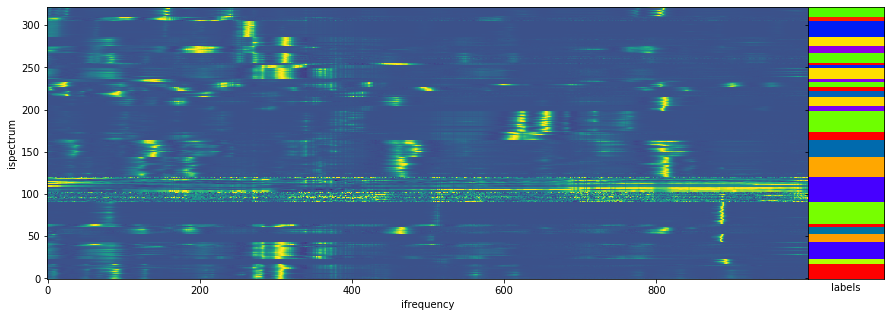

In [248]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, gridspec_kw={'wspace': 0, 'width_ratios':[10,1]})
ax1.imshow(X, origin='lower', aspect='auto')
ax2.imshow(y[:, None], origin='lower', aspect='auto', cmap='prism')
ax2.set_xticks([])
ax1.set_xlabel('ifrequency')
ax1.set_ylabel('ispectrum')
ax2.set_xlabel('labels')

## compute mean spectra and variances

In [249]:
nlabels = len(np.unique(y))
print(nlabels)

27


In [250]:
mean_spectra = np.vstack([ np.mean(X[iclass==y], axis=0) for iclass in range(nlabels) ])
var_spectra = np.vstack([ np.var(X[iclass==y], axis=0) for iclass in range(nlabels) ])

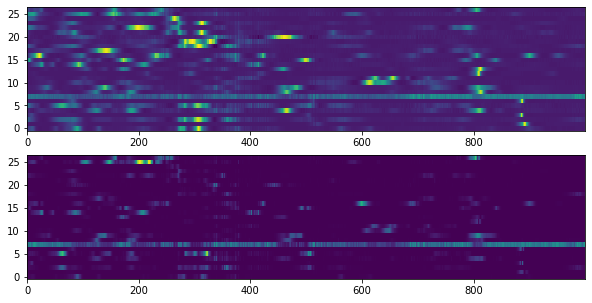

In [251]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(mean_spectra, origin='lower', aspect='auto')
ax2.imshow(var_spectra, origin='lower', aspect='auto')

## binary mixture - prepare synthetic data

In [252]:
nsynt = 10
synt_y = np.random.binomial(1, p=3./27., size=(nsynt, nlabels))

In [253]:
synt_X = np.zeros((nsynt, nfeatures))

for isample, mixture in enumerate(synt_y):
    for iclass, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == iclass]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

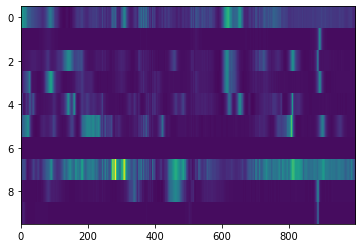

In [254]:
plt.figure()
plt.imshow(synt_X, aspect='auto')

[0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
(1000,)


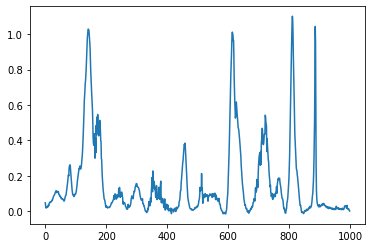

In [255]:
observation = synt_X[2]
mix = synt_y[2]
print(mix)
print(observation.shape)
plt.plot(observation)

## binary model - inference

In [256]:
import theano.tensor as tt
import pymc3 as pm
from theano.compile.ops import as_op

def logp(params):
    likelihood = -(observation - pm.math.sum(params[:, None] * mean_spectra, axis=0))**2 /pm.math.sum(0.5 * var_spectra, axis=0)
    return likelihood

In [210]:
with pm.Model() as model:
    params = pm.Binomial('params', n=1, p=0.5, shape=27)
    like = pm.Potential('like', logp(params))
    step = pm.BinaryGibbsMetropolis([params])
    trace = pm.sample(100, cores=10, step=step)

Only 100 samples in chain.
Multiprocess sampling (10 chains in 10 jobs)
BinaryGibbsMetropolis: [params]
Sampling 10 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1563.01draws/s]


In [211]:
trace.get_values('params')

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0]])

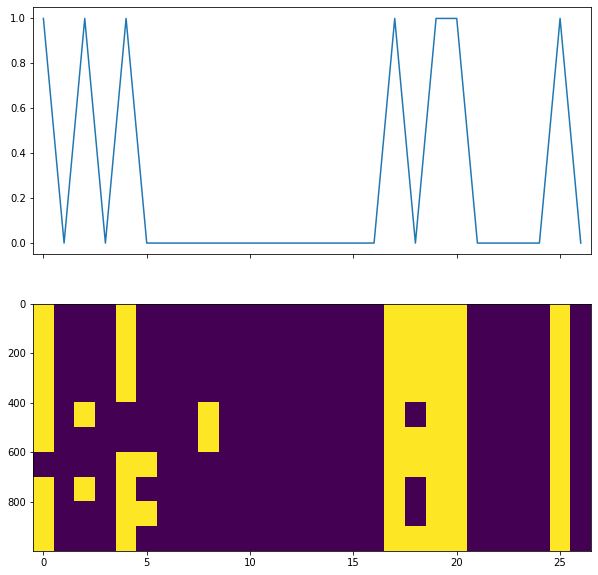

In [212]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(mix)
ax2.imshow(trace.get_values('params'), aspect='auto')

## non-binary mixture

In [261]:
nsynt = 10
synt_y = np.abs(np.random.laplace(loc=0, scale=0.5, size=(nsynt, nlabels)))

In [262]:
synt_X = np.zeros((nsynt, nfeatures))

for isample, mixture in enumerate(synt_y):
    for iclass, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == iclass]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

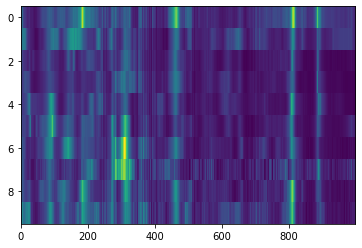

In [263]:
plt.figure()
plt.imshow(synt_X, aspect='auto')

[0.10561749 0.47041521 0.50588364 0.66397853 0.02340066 0.26752781
 0.81184169 0.13614677 0.10611387 1.05815219 0.28218764 0.35141375
 0.4693745  0.92202124 0.28646519 0.12043147 0.10552652 0.15598593
 0.22922344 0.19844273 0.84947689 0.66779737 0.36752675 0.200056
 0.64540026 0.10124675 1.18992373]
(1000,)


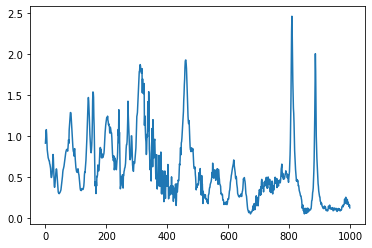

In [264]:
observation = synt_X[2]
mix = synt_y[2]
print(mix)
print(observation.shape)
plt.plot(observation)

In [265]:
def logp(params):
    likelihood = -(observation - pm.math.sum(params[:, None] * mean_spectra, axis=0))**2 /pm.math.sum(0.5 * var_spectra, axis=0)
    return likelihood

In [270]:
with pm.Model() as model2:
    params = pm.HalfNormal('params', sigma=0.5, shape=27)
    like = pm.Potential('like', logp(params))
    trace = pm.sample(100, cores=10)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [params]
Sampling 10 chains: 100%|██████████| 6000/6000 [00:13<00:00, 452.02draws/s]
The acceptance probability does not match the target. It is 0.8919250313275295, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30107511477145116, but should be close to 0.8. Try to increase the number of tuning steps.


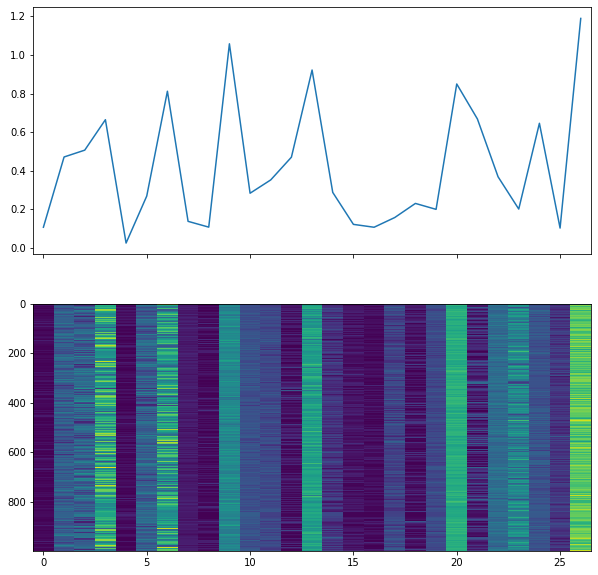

In [271]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(mix)
ax2.imshow(trace.get_values('params'), aspect='auto')